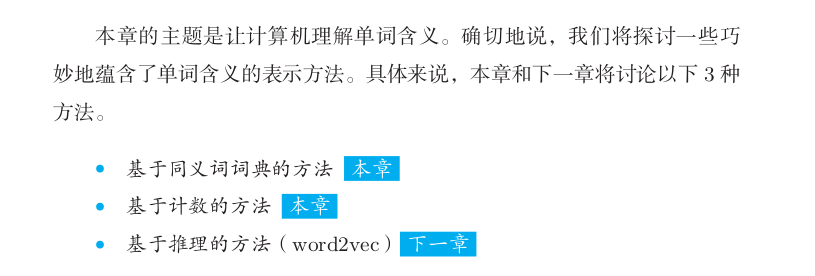

In [1]:
import numpy as np
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')
    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    corpus = np.array([word_to_id[w] for w in words])
    return corpus, word_to_id, id_to_word

In [2]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

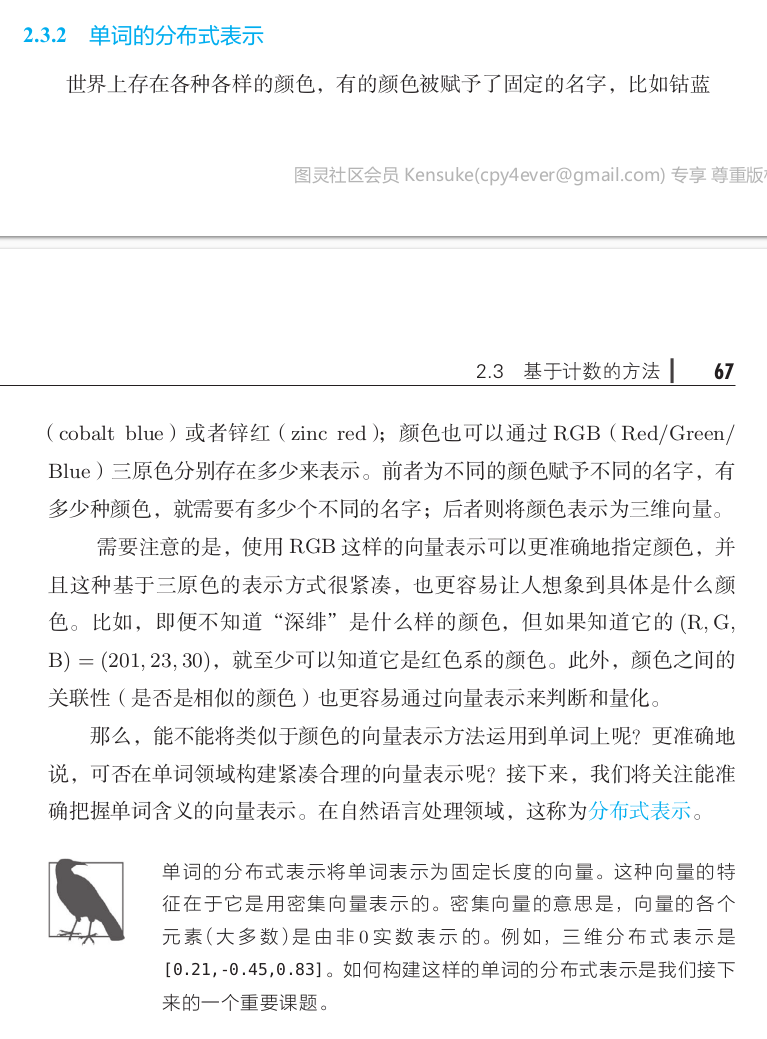

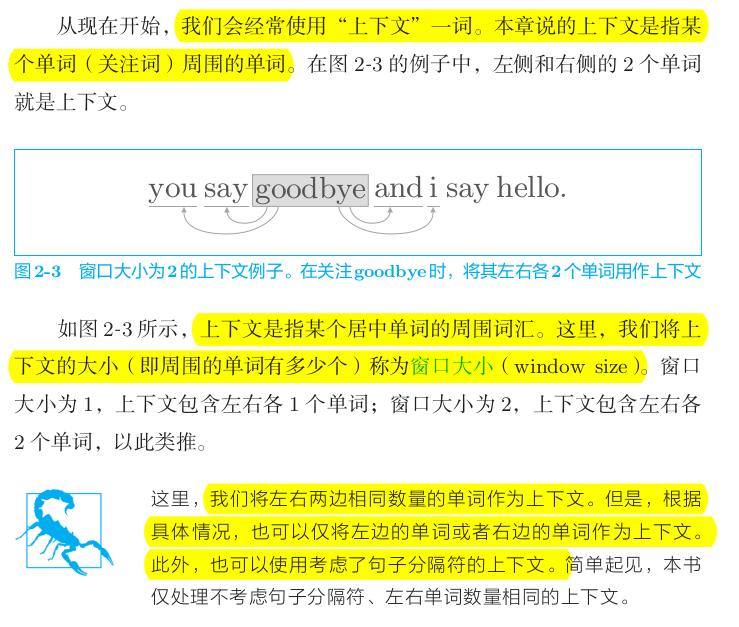

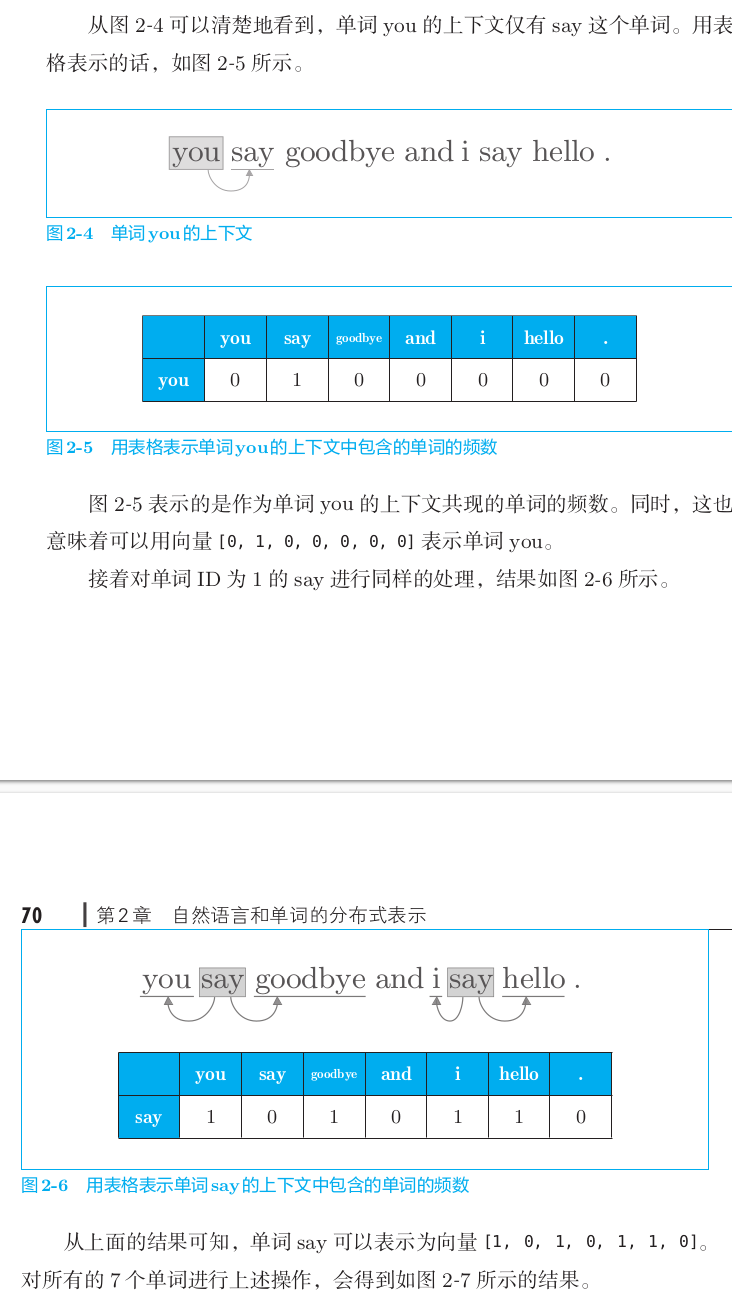

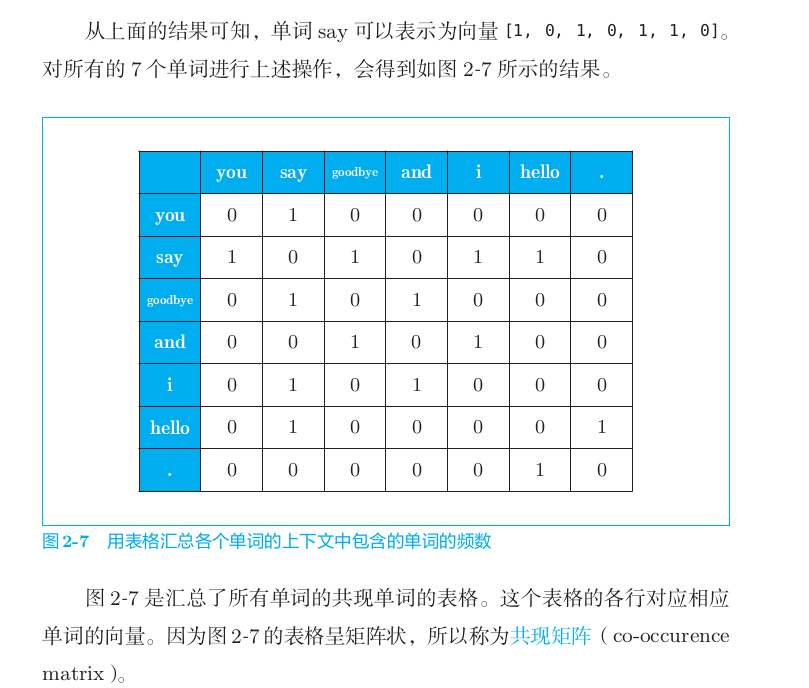

In [9]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size+1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
    return co_matrix

In [11]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(id_to_word)
C = create_co_matrix(corpus, vocab_size, window_size=1)
C

KeyboardInterrupt: 

In [8]:
C = np.array([
    [0, 1, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 1, 1, 0],
    [0, 1, 0, 1, 0, 0, 0],
    [0, 0, 1, 0, 1, 0, 0],
    [0, 1, 0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 1, 0],
    ], dtype=np.int32)
C[0, 1]

1

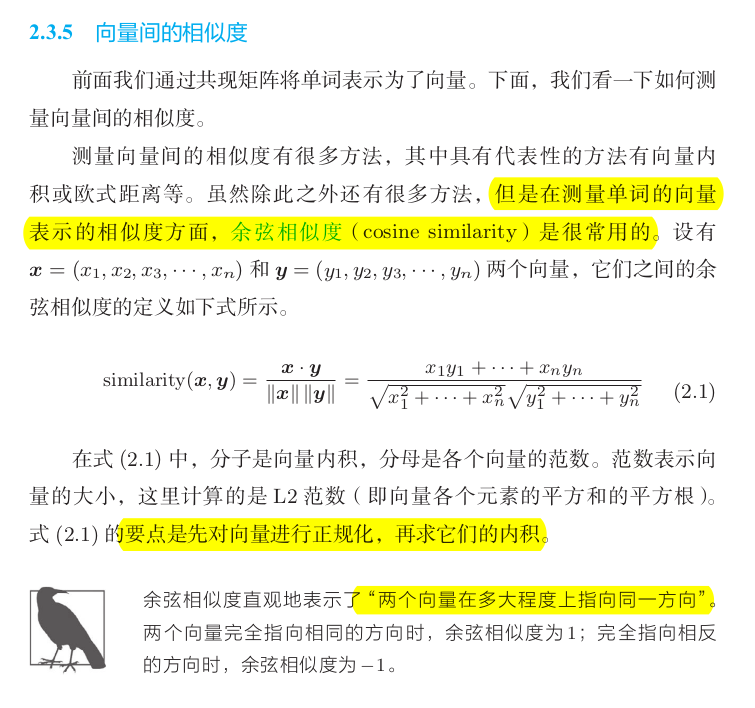

In [12]:
def cos_similarity(x, y):
    nx = x / np.sqrt(np.sum(x**2)) # x 的正规化
    ny = y / np.sqrt(np.sum(y**2)) # y 的正规化
    return np.dot(nx, ny)

def cos_similarity(x, y, eps=1e-8):
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)

In [13]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
c0 = C[word_to_id['you']]# you 的单词向量
c1 = C[word_to_id['i']]# i 的单词向量
print(cos_similarity(c0, c1))
# 0.7071067691154799

0.7071067691154799


In [14]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [15]:
word_to_id

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

In [16]:
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [ ]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    '''相似单词的查找

    :param query: 查询词
    :param word_to_id: 从单词到单词ID的字典
    :param id_to_word: 从单词ID到单词的字典
    :param word_matrix: 汇总了单词向量的矩阵，假定保存了与各行对应的单词向量
    :param top: 显示到前几位
    '''
    if query not in word_to_id:
        print('%s is not found' % query)
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    vocab_size = len(id_to_word)

    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return


这里使用 argsort() 方法对数
组的索引进行了重排。这个 argsort() 方法可以按升序对 NumPy 数组的元
素进行排序（不过，返回值是数组的索引）。

In [17]:
x = np.array([100, -20, 2])
x.argsort() #返回值是数组的索引

array([1, 2, 0])

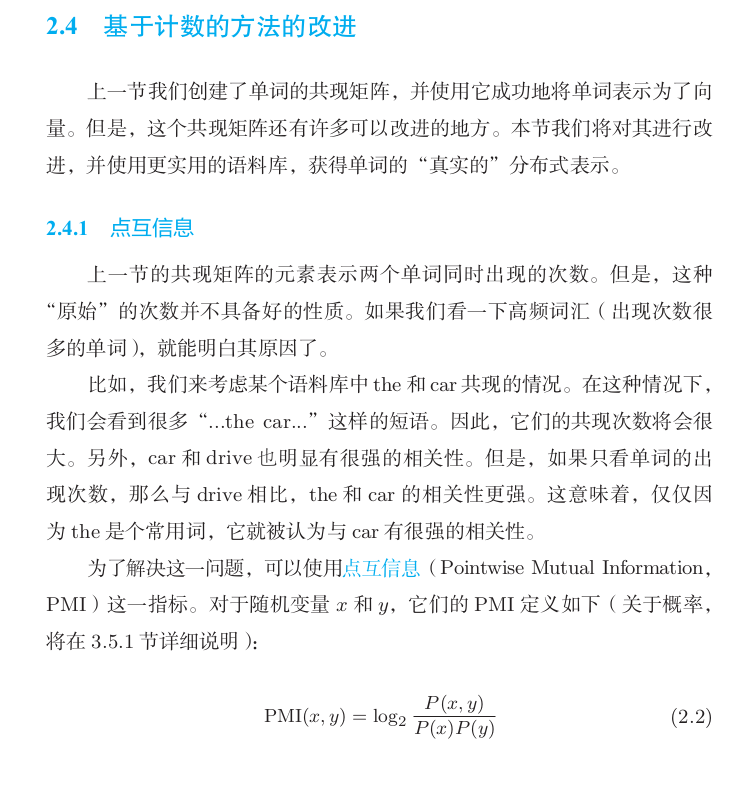

In [19]:
np.sum(C, axis=0)

array([1, 4, 2, 2, 2, 2, 1])

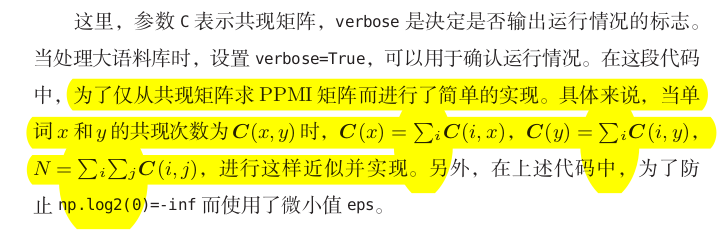

In [23]:
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[i] * S[j]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total // 100+1) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    
    return M

In [24]:
W = ppmi(C)
np.set_printoptions(precision=3) # 有效位数为 3位
print('covariance matrix')
print(C)
print('-'*50)
print('PPMI')
print(W)

covariance matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


In [27]:
U, S, V = np.linalg.svd(W)
U

array([[-3.409e-01, -1.110e-16, -3.886e-16, -1.205e-01,  0.000e+00,
         9.323e-01,  2.226e-16],
       [ 0.000e+00, -5.976e-01,  1.802e-01,  0.000e+00, -7.812e-01,
         0.000e+00,  0.000e+00],
       [-4.363e-01, -4.241e-17, -2.172e-16, -5.088e-01, -1.767e-17,
        -2.253e-01, -7.071e-01],
       [-2.614e-16, -4.978e-01,  6.804e-01, -6.574e-17,  5.378e-01,
         9.951e-17,  1.201e-17],
       [-4.363e-01, -3.229e-17, -1.654e-16, -5.088e-01, -1.345e-17,
        -2.253e-01,  7.071e-01],
       [-7.092e-01, -3.229e-17, -1.654e-16,  6.839e-01, -1.345e-17,
        -1.710e-01,  5.889e-17],
       [ 3.056e-16, -6.285e-01, -7.103e-01,  8.846e-17,  3.169e-01,
        -2.847e-16, -1.546e-17]], dtype=float32)

In [28]:
S

array([3.168e+00, 3.168e+00, 2.703e+00, 2.703e+00, 1.514e+00, 1.514e+00,
       1.484e-16], dtype=float32)

In [29]:
V

array([[ 0.000e+00, -5.976e-01, -2.296e-16, -4.978e-01, -1.186e-16,
         2.145e-16, -6.285e-01],
       [-3.409e-01, -1.110e-16, -4.363e-01,  0.000e+00, -4.363e-01,
        -7.092e-01,  0.000e+00],
       [ 1.205e-01, -5.551e-16,  5.088e-01,  0.000e+00,  5.088e-01,
        -6.839e-01,  0.000e+00],
       [-0.000e+00, -1.802e-01, -1.586e-16, -6.804e-01,  6.344e-17,
         9.119e-17,  7.103e-01],
       [-9.323e-01, -5.551e-17,  2.253e-01,  0.000e+00,  2.253e-01,
         1.710e-01,  0.000e+00],
       [-0.000e+00,  7.812e-01,  2.279e-16, -5.378e-01,  3.390e-16,
        -2.717e-16, -3.169e-01],
       [ 0.000e+00,  2.632e-16, -7.071e-01,  8.043e-18,  7.071e-01,
         9.088e-17,  1.831e-17]], dtype=float32)

In [30]:
import matplotlib.pyplot as plt

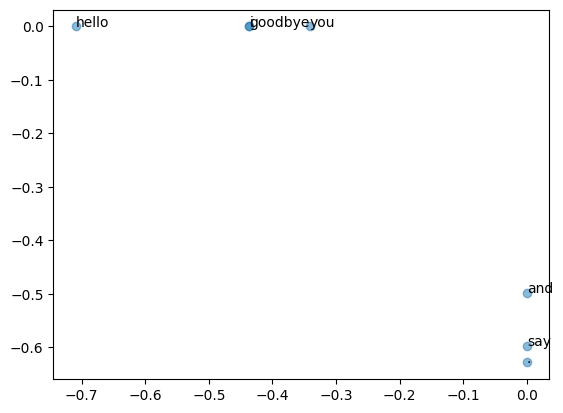

In [31]:
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

In [33]:
print(C[0]) # 共现矩阵
print(W[0]) # PPMI 矩阵
print(U[0]) #SVD 原先的稀疏向量 W[0] 经过 SVD 被转化成了密集向量 U[0]。2.4 基于计数的方法的改进如果要对这个密集向量降维，比如把它降维到二维向量，取出前两个元素即可。
print(U[0, :2])

[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[-3.409e-01 -1.110e-16 -3.886e-16 -1.205e-01  0.000e+00  9.323e-01
  2.226e-16]
[-3.409e-01 -1.110e-16]


Word2vector, 可以有多个输入层，输入层权重Win，输入层时context，输出层是各个词的概率，也就是context中间的那个单词出现的概率。每个输入层一般是一个单词的one-hot表示向量。Win一般被用来作为单词的分布式表示。

CBOW是从多个单词预测一个目标词
Skip-gram是反过来的，从一个目标词预测多个单词（上下文）因为skip-gram预测难度更大，因此其参数矩阵更好能体现单词分布规律
word2vec可以进行权重的增量学习，所以能高效的更新或者添加新的单词分布表示。

1. embedding 层解决输入层的one-hot表示和Win的乘积
2. 负采样解决中间层和Wout的乘积以及softmax的计算。

word2vec 分布式表示可以用在各种自然语言的任务中，推理，相似度，情感分析，等等

word2vec 是单向的，比如you say 和say you 作为输入是一样的。因此用RNN来解决